# Lab 5: Error mitigation with Qiskit Runtime

In this lab, we'll explore a few of the error mitigation options available through Qiskit Runtime. Specifically, we'll define a simple observable and initial state and use the Estimator primitive to measure the expectation value. Using noisy simulations, we'll explore the effect of different error mitigation strategies.

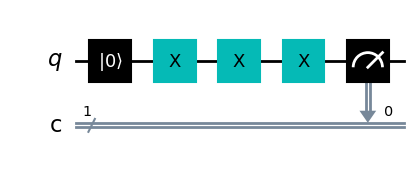

In [13]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)
    qc.reset(0)
    for i in range (d):
        qc.x(0)
    qc.measure(0,0)

    ####### your code goes here #######

    return qc

d = 3
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")

In [ ]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

In [28]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)
    qc.x(0)
    for i in range (d):
        qc.z(0)
    qc.measure(0,0)

    ####### your code goes here #######

    return qc

d = 100
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
#qc.draw("mpl")

In [17]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'0': 1000}

In [30]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
hub = "quantum-explorer"
group = "group-4"
project = "project-2"

backend_name = "ibmq_manila"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

Traceback (most recent call last):
  Cell In[30], line 9
    backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_provider/ibm_provider.py:656 in get_backend
    backends = self.backends(name, instance=instance, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_provider/ibm_provider.py:557 in backends
    return self._backend.backends(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_provider/ibm_backend_service.py:168 in backends
    self._backends[name] = self._create_backend_obj(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_provider/ibm_backend_service.py:709 in _create_backend_obj
    raise QiskitBackendNotFoundError(
QiskitBackendNotFoundError: 'Backend ibmq_manila is not in quantum-explorer/group-4/project-2: please try a different hub/group/project.'

Use %tb to get the full traceback.


## Setup

We'll define a simple Heisenberg Hamiltonian model to use as an example. We'll also construct a simple state preparation circuit.

In [14]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp


def heisenberg_hamiltonian(
    length: int, jx: float = 1.0, jy: float = 0.0, jz: float = 0.0
) -> SparsePauliOp:
    terms = []
    for i in range(length - 1):
        if jx:
            terms.append(("XX", [i, i + 1], jx))
        if jy:
            terms.append(("YY", [i, i + 1], jy))
        if jz:
            terms.append(("ZZ", [i, i + 1], jz))
    return SparsePauliOp.from_sparse_list(terms, num_qubits=length)


def state_prep_circuit(num_qubits: int, layers: int = 1) -> QuantumCircuit:
    qubits = QuantumRegister(num_qubits, name="q")
    circuit = QuantumCircuit(qubits)
    circuit.h(qubits)
    for _ in range(layers):
        for i in range(0, num_qubits - 1, 2):
            circuit.cx(qubits[i], qubits[i + 1])
        circuit.ry(0.1, qubits)
        for i in range(1, num_qubits - 1, 2):
            circuit.cx(qubits[i], qubits[i + 1])
        circuit.ry(0.1, qubits)
    return circuit

SparsePauliOp(['IIIXX', 'IIIYY', 'IIXXI', 'IIYYI', 'IXXII', 'IYYII', 'XXIII', 'YYIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


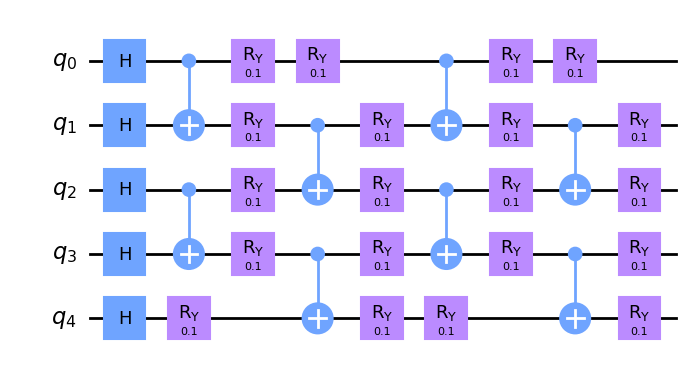

In [15]:
length = 5

hamiltonian = heisenberg_hamiltonian(length, 1.0, 1.0)
circuit = state_prep_circuit(length, layers=2)

print(hamiltonian)
circuit.draw("mpl")

## Calculate exact expectation value (energy)

First, we'll calculate the exact expectation value using a local simulator implementation of the Estimator primitive. The expectation value of a Hamiltonian is also referred to as "energy."

In [16]:
from qiskit_aer.primitives import Estimator

estimator = Estimator(approximation=True)
job = estimator.run(circuit, hamiltonian, shots=None)
result = job.result()
exact_value = result.values[0]

print(f"Exact energy: {exact_value}")

Exact energy: 4.290938711029713


## Run noisy simulation through Qiskit Runtime

Next, we'll initialize the Qiskit Runtime service and switch to using its Estimator primitive, backed by a simulator that can handle noise. Even though our circuit acts on 5 qubits, we'll initialize a simulator with 6 qubits in order to later demonstrate the potential effects of qubit choice.

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService

hub = "summer-school-2"
group = "group-9"
project = "8100574839"
service = QiskitRuntimeService(instance=f"{hub}/{group}/{project}")

In [23]:
from qiskit_ibm_runtime import Estimator, Options, Session
from qiskit.transpiler import CouplingMap

backend = service.get_backend("simulator_statevector")
# set simulation options
simulator = {
    "basis_gates": ["id", "rz", "sx", "cx", "reset"],
    "coupling_map": list(CouplingMap.from_line(length + 1)),
}
shots = 10000

### No noise

First, we'll run the simulation with no noise.

In [24]:
import math

options = Options(
    simulator=simulator,
    resilience_level=0,
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.3144
Energy error: 0.023461288970286986
Variance: 4.443663519999999
Standard error: 0.021079998861480043


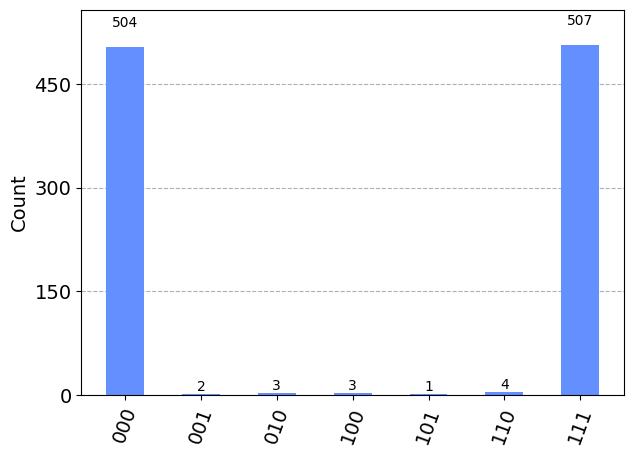

In [3]:
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo


# Build noise model from backend properties
backend = FakeVigo()
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates)
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)

### Readout error

Next, let's run a simulation with readout error.

#### Exercise 1

In this exercise, you'll construct a noise model that has modest readout error on all qubits except for the first qubit, which will have really bad readout error.

Specifically, construct a noise model with the following properties:
- For the first qubit (qubit 0):
  - A readout of 1 has a 50% probability of being erroneously read as 0.
  - A readout of 0 has a 20% probability of being erroneously read as 1.
- For the rest of the qubits:
  - A readout of 1 has a 5% probability of being erroneously read as 0.
  - A readout of 0 has a 2% probability of being erroneously read as 1.

You may find it helpful to consult the following resources:
  - https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html
  - https://qiskit.org/ecosystem/aer/tutorials/3_building_noise_models.html
  

In [6]:
#for first qubit 0
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

p0given1 = 0.5
p1given0 = 0.2

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.8 0.2]
 [0.5 0.5]])

In [7]:
#for other qubits
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

p0given1 = 0.05
p1given0 = 0.02

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.98 0.02]
 [0.05 0.95]])

In [11]:
from qiskit_aer.noise import NoiseModel, ReadoutError

# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors


# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

#error_1 = noise.ReadoutError(prob_1, 1)
#error_2 = noise.ReadoutError(prob_2, 2)

noise_model = NoiseModel() #create empty noise model
# Add depolarizing error to all single qubit u1, u2, u3 gates
noise_model.add_readout_error(ReadoutError([[0.8, 0.2],[0.5, 0.5]]),[0])
for i in range(5):
    noise_model.add_readout_error(ReadoutError([[0.98, 0.02],[0.05, 0.95]]),[i+1])

##### your code here #####

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5]
  Specific qubit errors: [('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,))]


In [12]:
# Submit your answer

from qc_grader.challenges.qgss_2023 import grade_lab5_ex1

grade_lab5_ex1(noise_model)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


First, let's try running the simulation without doing anything to mitigate the readout error. We'll explicitly set `resilience_level = 0` to ensure that no error mitigation is applied by the Runtime service. To illustrate the effect of a poor choice of qubits, we'll explicitly specify an initial layout that includes qubit 0.

In [25]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=0,
    transpilation=dict(initial_layout=list(range(length))),
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 3.5793999999999997
Energy error: 0.7115387110297133
Variance: 5.35425548
Standard error: 0.02313926420610647


The error we get is pretty large. To improve things, let's pick a qubit layout that avoids qubit 0.

In [26]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=0,
    transpilation=dict(initial_layout=list(range(1, length + 1))),
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 3.9084000000000003
Energy error: 0.3825387110297127
Variance: 5.01531904
Standard error: 0.02239490799266655


The error is smaller now, but still significant. Let's now enable readout error mitigation by setting `resilience_level = 1`.

In [27]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=1,
    transpilation=dict(initial_layout=list(range(1, length + 1))),
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.251123274555114
Energy error: 0.03981543647459862
Variance: 7.035043370026496
Standard error: 0.026523656177130813


Now, the effect of readout error has been almost completely mitigated! This mitigation did not come for free. In particular,
- To perform readout error mitigation, the Runtime service has to run additional calibration circuits, so the overall running time may be longer.
- The variance of the estimator has increased, leading to a larger standard error of the mean. As a consequence, a larger number of shots needs to be specified in order to achieve a given standard error.

Typically, these costs are relatively small, so it is almost always worthwhile to enable readout error mitigation.

#### Exercise 2

Suppose that turning on readout error mitigation increases the variance of your estimator by a factor of 2. If you originally ran your experiment with 10,000 shots, how many shots should you now use to achieve the same standard error of the mean?

In [32]:
new_shots = 20000

##### your code here #####


In [33]:
# Submit your answer

from qc_grader.challenges.qgss_2023 import grade_lab5_ex2

grade_lab5_ex2(new_shots)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Depolarizing error and zero-noise extrapolation

In this section, we will see how depolarizing error can be mitigated using zero-noise extrapolation. Because the zero-noise extrapolation feature of Qiskit Runtime is still in beta, it currently has a few limitations. In particular, as of the time of this writing, the zero-noise extrapolation feature does not mitigate readout error. Therefore, in the examples below, we will remove readout error from our noise model.

#### Exercise 3

Construct a noise model that adds two-qubit depolarizing error after each CNOT gate, such that the error channel maps the input quantum state to the completely mixed state with 1% probability.

In [ ]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  Qubits with noise: [1, 2, 3, 4, 5]
  Specific qubit errors: [('u1', (1,)), ('u1', (2,)), ('u1', (3,)), ('u1', (4,)), ('u1', (5,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,))]


In [44]:
from qiskit_aer.noise import depolarizing_error

# Error probabilities
#prob_1 = 0.01  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

noise_model = NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

##### your code here #####

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


In [45]:
# Submit your answer

from qc_grader.challenges.qgss_2023 import grade_lab5_ex3

grade_lab5_ex3(noise_model)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Let's run the estimator with `resilience_level = 1`, which turns on readout error mitigation. Because our noise model doesn't include readout error mitigation, we don't expect this to help.

In [46]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=1,
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.066
Energy error: 0.2249387110297132
Variance: 4.8139288
Standard error: 0.021940667264237886


As expected, the error we get is pretty significant.

Now, let's turn on zero-noise extrapolation by setting `resilience_level = 2`.

In [47]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=2,
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variances = result.metadata[0]["zne"]["noise_amplification"]["variance"]

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variances: {variances}")

Estimated energy: 4.215816666666669
Energy error: 0.07512204436304426
Variances: [4.84024324, 5.43555636, 5.89646712]


Now, the effect of depolarizing noise has been almost completely mitigated! Note that instead of getting a single variance value for the estimator, we are now returned a list of variances, one for each data point measured for the extrapolation. In a future version of Qiskit Runtime, these variances will also be extrapolated to return a single variance for the final estimator.

#### Exercise 4 (ungraded)

Besides depolarizing error, what other kinds of noise can be mitigated by zero-noise extrapolation? Test your proposals by constructing other noise models, and then simulating them with and without zero-noise extrapolation.